In [1]:
%load_ext autoreload
%autoreload 2

from bosonicplus.optimizer import GBS_optimizer
from bosonicplus.cost_functions import symm_effective_squeezing_gradients, symm_effective_squeezing, state_prep_GBS, gkp_squeezing, gkp_squeezing_gradients
from bosonicplus.plotting import plot_wigner_marginals
from bosonicplus.effective_sqz import effective_sqz
from bosonicplus.conversions import dB_to_Delta, Delta_to_dB
import numpy as np
import matplotlib.pyplot as plt

## Optimising a GBS circuit

In [2]:
opt = GBS_optimizer(4,
                    pattern = [3,3,3], 
                    inf = 1e-4, 
                    bs_arrange='Clements',
                    gradients = True,
                    costf_lattice = 's',
                    costf = symm_effective_squeezing_gradients,
                   )

np.random.seed(28)

opt.set_initial_guess()
print(opt.num_params)
print(opt.init_costf)

10
(0.7747958869599822, array([ 0.03696073,  0.02641162,  0.21265763, -0.07333507, -0.03792817,
        0.39184393, -2.04548818,  0.39020368,  0.46494381, -0.26454098]))


In [3]:
opt.run_global_optimisation(niter = 50)
print(opt.result.fun)
print(opt.result)

basinhopping step 0: f 0.478024
basinhopping step 1: f 0.46314 trial_f 0.46314 accepted 1  lowest_f 0.46314
found new global minimum on step 1 with function value 0.46314
basinhopping step 2: f 0.46314 trial_f 1.03192 accepted 0  lowest_f 0.46314
basinhopping step 3: f 0.717337 trial_f 0.717337 accepted 1  lowest_f 0.46314
basinhopping step 4: f 0.422839 trial_f 0.422839 accepted 1  lowest_f 0.422839
found new global minimum on step 4 with function value 0.422839
basinhopping step 5: f 0.494032 trial_f 0.494032 accepted 1  lowest_f 0.422839
basinhopping step 6: f 0.485928 trial_f 0.485928 accepted 1  lowest_f 0.422839
basinhopping step 7: f 0.480041 trial_f 0.480041 accepted 1  lowest_f 0.422839
basinhopping step 8: f 0.480041 trial_f 0.719812 accepted 0  lowest_f 0.422839
basinhopping step 9: f 0.660632 trial_f 0.660632 accepted 1  lowest_f 0.422839
basinhopping step 10: f 0.717736 trial_f 0.717736 accepted 1  lowest_f 0.422839
basinhopping step 11: f 0.479422 trial_f 0.479422 accepte

/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/effective_sqz.py:89: RuntimeWarning: invalid value encountered in sqrt
  Delta =  0.5 * (np.sqrt(D1)+np.sqrt(D2))
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/effective_sqz.py:90: RuntimeWarning: invalid value encountered in sqrt
  dDelta =  0.25/np.sqrt(D1)*dD1+0.25/np.sqrt(D2)*dD2
/Users/s163967/venv/241104-bp/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2371: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/charfun.py:142: RuntimeWarning: invalid value encountered in divide
  charf_gradients = charf_gradient1/state.norm - charf/state.norm**2 * charf_gradient2
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/boso

basinhopping step 29: f 0.532302 trial_f 2.89819 accepted 0  lowest_f 0.422839
basinhopping step 30: f 0.539536 trial_f 0.539536 accepted 1  lowest_f 0.422839
basinhopping step 31: f 0.543967 trial_f 0.543967 accepted 1  lowest_f 0.422839
basinhopping step 32: f 0.52352 trial_f 0.52352 accepted 1  lowest_f 0.422839
basinhopping step 33: f 0.586696 trial_f 0.586696 accepted 1  lowest_f 0.422839
basinhopping step 34: f 0.463234 trial_f 0.463234 accepted 1  lowest_f 0.422839
basinhopping step 35: f 0.532133 trial_f 0.532133 accepted 1  lowest_f 0.422839
basinhopping step 36: f 0.492308 trial_f 0.492308 accepted 1  lowest_f 0.422839
basinhopping step 37: f 0.550961 trial_f 0.550961 accepted 1  lowest_f 0.422839
basinhopping step 38: f 0.531194 trial_f 0.531194 accepted 1  lowest_f 0.422839
basinhopping step 39: f 0.549969 trial_f 0.549969 accepted 1  lowest_f 0.422839
basinhopping step 40: f 0.443024 trial_f 0.443024 accepted 1  lowest_f 0.422839
basinhopping step 41: f 0.443024 trial_f 1.

Probability 0.0005335189483282878
Delta_x 0.40917553927764744
Delta_p 0.43562082959077275
symm Delta [dB] 7.481305469297387


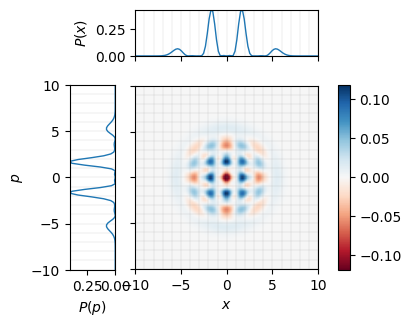

In [4]:
#Plot the output state

opt.set_initial_guess(params = opt.res_dict)
#pattern = (5,5,5)
pattern = opt.pattern

args = (opt.num_modes, 
        pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR,  
        False, #no gradients
        opt.inf,
        True) #fast rep


out = state_prep_GBS(opt.result.x, *args)
print('Probability', out.norm)
out.reduce(np.sum(pattern))
Dx = effective_sqz(out, 'sx')
Dp = effective_sqz(out, 'sp')
print('Delta_x', Dx)
print('Delta_p', Dp)
print('symm Delta [dB]', Delta_to_dB(np.sqrt(0.5*(Dx**2+Dp**2))))
x = np.linspace(-10,10,100)
W = out.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()

## Other photon number patterns of optimal circuit


In [5]:
#check that the measurement probability sums to 1 of other patterns (up to a cutoff).
from itertools import product
prob = 0
cutoff = 12
patterns = list(product(range(cutoff), repeat=opt.num_modes-1))
print('pattern | norm | Delta_x | Delta_p | Delta_y')
for pattern in patterns: 
    
    args = (opt.result.x,
        opt.num_modes, 
        pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR, 
        False, #no gradients
        opt.inf, 
        True) #fast rep
    
    out = state_prep_GBS(*args)
    Delta_x=effective_sqz(out, 'sx')
    Delta_p=effective_sqz(out, 'sp')
    Delta_y = np.sqrt(0.5 * (Delta_x**2+Delta_p**2))
    if Delta_x < 0.5 or Delta_p < 0.5:
        print(pattern, out.norm, Delta_x, Delta_p, Delta_y)
    
    if out.norm > 0:
        prob += out.norm
   

print('total prob', prob) 

pattern | norm | Delta_x | Delta_p | Delta_y
(1, 3, 3) 0.0008720651260688718 0.4871679831138781 0.9309934313675073 0.742994418895825
(2, 0, 4) 0.004113993435641019 0.4659507741351464 0.7749371017946115 0.6393894101621383
(2, 0, 6) 0.00204279331071389 0.4772792926401212 1.3036345052711749 0.9816461802800119
(2, 0, 8) 0.0011521632695532054 0.47196830843276716 0.9434532334979837 0.7459417162093459
(2, 0, 10) 0.0006981844587861194 0.48056845274648213 0.7418161870677705 0.6249949172476978
(2, 2, 4) 0.000976615840805398 0.435661642020668 0.4835669063362764 0.46023799236470136
(2, 4, 2) 0.0004306800146664475 0.4340014755325481 0.49554961350658444 0.4657932482394706
(2, 6, 0) 0.00020764302753232622 0.48272774027089516 2.406504784862384 1.7355534204962682
(2, 6, 1) 9.193014982571584e-05 1.1382360130476896 0.4965730180917084 0.8781133137857006
(2, 8, 0) 5.252750575479836e-05 0.4103151772448088 0.8367936472017036 0.6590076451281002
(2, 10, 0) 1.4482030035521431e-05 0.3883574237091335 0.6938587695

## Same optimisation, but without gradients

In [6]:
opt = GBS_optimizer(4, 
                    pattern = [3,3,3], 
                    inf = 1e-4, 
                    bs_arrange='Clements',
                    costf_lattice = 's',
                    costf = symm_effective_squeezing
                   )
np.random.seed(12)
opt.set_initial_guess()
print(opt.init_costf)

1.0847137647145606


In [7]:
opt.run_global_optimisation(niter = 30)
print(opt.result.fun)
print(opt.result)

basinhopping step 0: f 0.708068
basinhopping step 1: f 0.507253 trial_f 0.507253 accepted 1  lowest_f 0.507253
found new global minimum on step 1 with function value 0.507253
basinhopping step 2: f 0.74505 trial_f 0.74505 accepted 1  lowest_f 0.507253


/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/effective_sqz.py:61: RuntimeWarning: invalid value encountered in sqrt
  D1 = np.sqrt(-2/np.abs(alpha)**2*np.log(np.abs(f1)))
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/effective_sqz.py:62: RuntimeWarning: invalid value encountered in sqrt
  D2 = np.sqrt(-2/np.abs(alpha)**2*np.log(np.abs(f2)))


basinhopping step 3: f 0.635898 trial_f 0.635898 accepted 1  lowest_f 0.507253
basinhopping step 4: f 0.510359 trial_f 0.510359 accepted 1  lowest_f 0.507253
basinhopping step 5: f 0.536001 trial_f 0.536001 accepted 1  lowest_f 0.507253
basinhopping step 6: f 0.536001 trial_f 0.602191 accepted 0  lowest_f 0.507253
basinhopping step 7: f 0.729223 trial_f 0.729223 accepted 1  lowest_f 0.507253
basinhopping step 8: f 0.729223 trial_f 0.966146 accepted 0  lowest_f 0.507253
basinhopping step 9: f 0.469842 trial_f 0.469842 accepted 1  lowest_f 0.469842
found new global minimum on step 9 with function value 0.469842
basinhopping step 10: f 0.636902 trial_f 0.636902 accepted 1  lowest_f 0.469842
basinhopping step 11: f 0.636902 trial_f 1.51469 accepted 0  lowest_f 0.469842
basinhopping step 12: f 0.527295 trial_f 0.527295 accepted 1  lowest_f 0.469842
basinhopping step 13: f 0.537009 trial_f 0.537009 accepted 1  lowest_f 0.469842
basinhopping step 14: f 0.764325 trial_f 0.764325 accepted 1  lo

Probability 0.00033857686233464346
Delta_x 0.680602278956816
Delta_p 0.23463013022771548


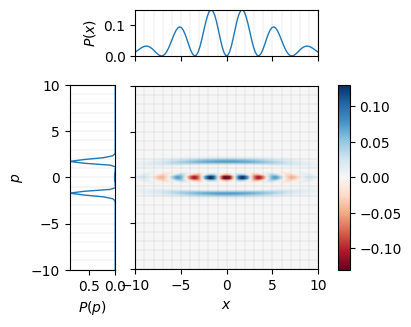

In [8]:
#Plot the output state

opt.set_initial_guess(params = opt.res_dict)

args = (opt.num_modes, 
        opt.pattern, 
        opt.bs_arrange, 
        opt.setting, 
        opt.etas, 
        opt.nbars, 
        opt.pPNR,  
        False, #no gradients
        opt.inf,
        True) #fast rep

out = state_prep_GBS(opt.result.x, *args)
print('Probability', out.norm)
out.reduce(np.sum(opt.pattern))
print('Delta_x', effective_sqz(out, 'sx'))
print('Delta_p', effective_sqz(out, 'sp'))
x = np.linspace(-10,10,100)
W = out.get_wigner_log(x,x)
plot_wigner_marginals(W.real,x,x)
plt.show()